In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from apyori import apriori

import datetime

import statsmodels.api as sm

from scipy.stats import spearmanr 

from sklearn.impute import SimpleImputer

from scipy.spatial.distance import cdist 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.feature_selection import RFECV

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


import joblib

from math import radians, cos, sin, asin, sqrt
from numpy import mean
from numpy import std

imp_df = pd.read_csv('./dataset_w_weather&rwi&city.csv')

---------Top 10----------


,Features,Score
29,city,1.00
21,latitude,1.00
26,Month,1.00
24,weather,1.00
22,longitude,1.00
28,rwi,0.96
0,Date,0.92
5,Age_Range,0.88
27,Year,0.84
18,TimeSpent_minutes,0.80


---------Bottom 10----------


,Features,Score
2,Race,0.32
6,With_Kids,0.32
1,Time,0.32
16,Dryer_No,0.24
4,Body_Size,0.20
23,Num_of_Baskets,0.16
14,Wash_Item,0.12
11,shirt_type,0.08
13,pants_type,0.04
3,Gender,0.00


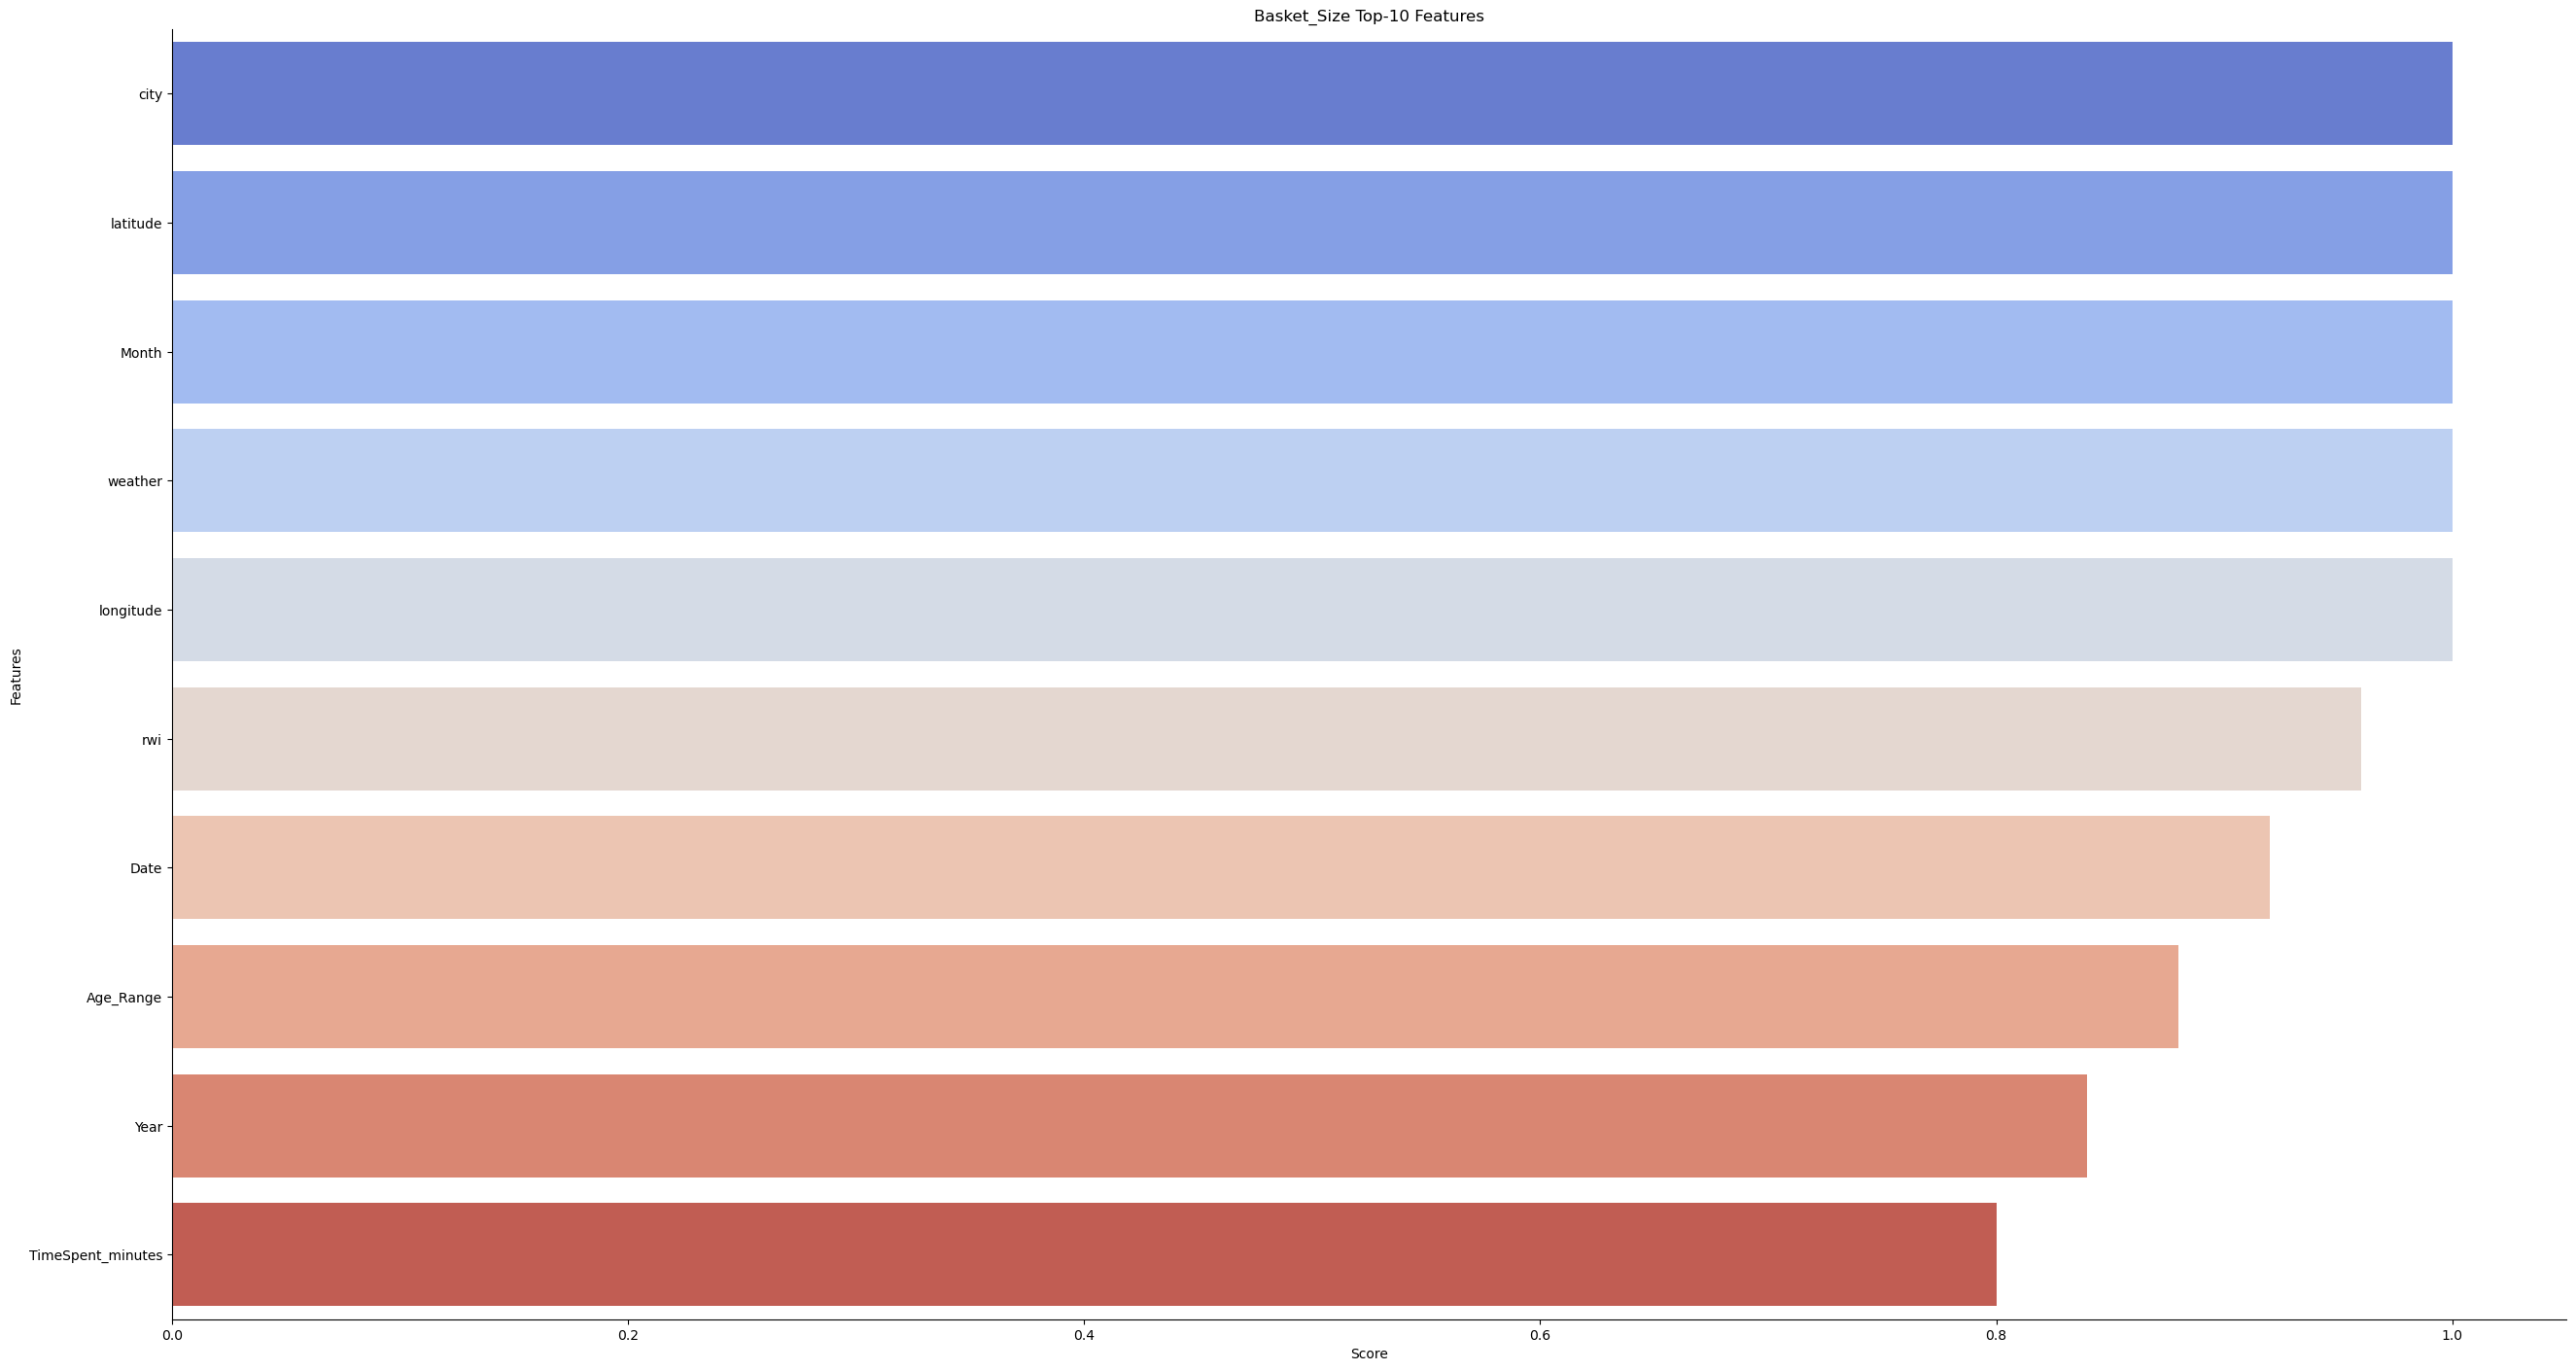

In [12]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
  
cwi_df = pd.read_csv('./dataset_w_weather&rwi&city.csv')

fs_df = cwi_df.apply(LabelEncoder().fit_transform)

X = fs_df.drop(['Basket_Size'], axis=1)
y = fs_df['Basket_Size']

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)
feat_selector.fit(X.values, y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), X.columns, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
display(boruta_score.tail(10))

sns_cwi_plot = sns.catplot(x="Score", y="Features", data = boruta_score[0:10], kind = "bar", height=14, aspect=1.9, palette='coolwarm')
plt.title("Basket_Size Top-10 Features")
sns_cwi_plot.figure.savefig('Basket_Size_Boruta.png')

---------Top 10----------


,Features,Score
26,Month,1.00
24,weather,1.00
22,longitude,1.00
21,latitude,1.00
18,TimeSpent_minutes,0.96
29,city,0.92
0,Date,0.88
5,Age_Range,0.85
28,rwi,0.81
12,Pants_Colour,0.77


---------Bottom 10----------


,Features,Score
16,Dryer_No,0.35
2,Race,0.31
4,Body_Size,0.27
6,With_Kids,0.23
23,Num_of_Baskets,0.19
14,Wash_Item,0.15
11,shirt_type,0.12
13,pants_type,0.08
17,Spectacles,0.04
3,Gender,0.00


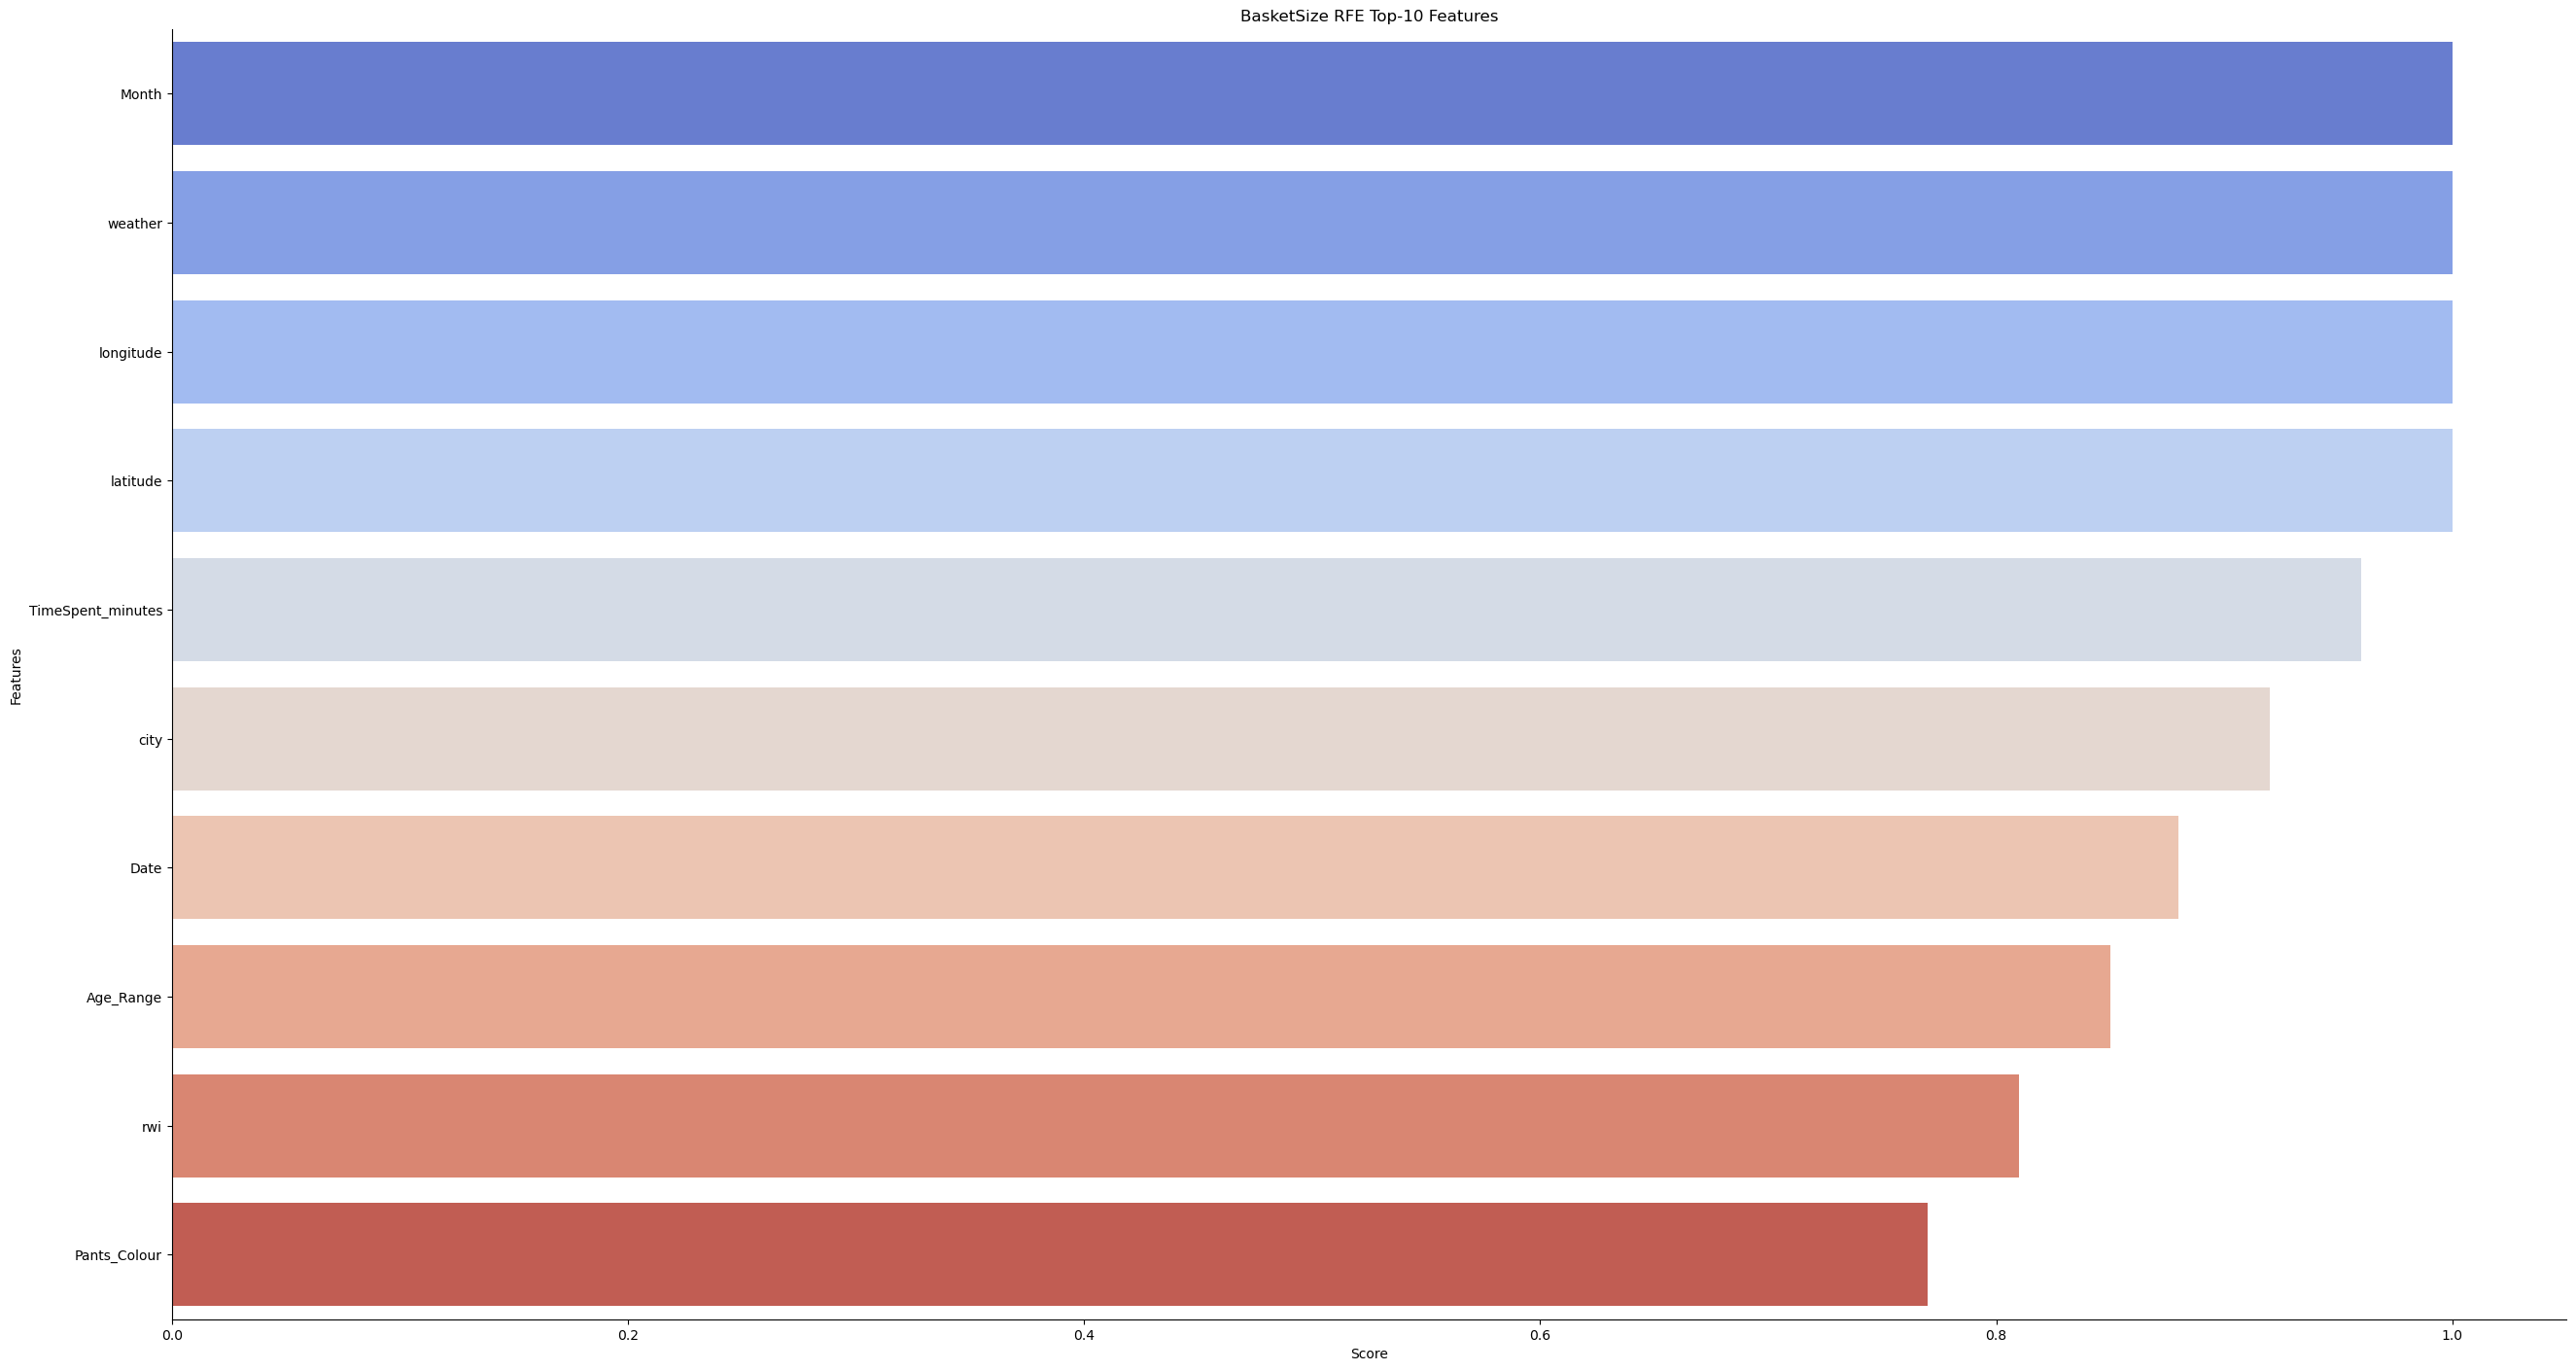

In [13]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5, n_estimators=100)
rf.fit(X, y)
rfe = RFECV(rf, min_features_to_select = 1, cv = 3)
rfe.fit(X, y)

rfe_score = ranking(list(map(float, rfe.ranking_)), X.columns, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(rfe_score.head(10))

print('---------Bottom 10----------')
display(rfe_score.tail(10))
pd.DataFrame.to_csv(rfe_score.head(10), 'BasketSize_RFE_Top10.csv')

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[0:10], kind = "bar", height=14, aspect=1.9, palette='coolwarm')
plt.title("BasketSize RFE Top-10 Features")
sns_rfe_plot.figure.savefig('BasketSize_RFE.png')

In [15]:
X = fs_df[["city", "Month", "weather", "rwi", "Age_Range", "TimeSpent_minutes"]]
y = fs_df['Basket_Size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) 

## Naive Bayes

In [16]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
filename = 'Basket_Size_NB.sav'
joblib.dump(nb, filename)

print("Accuracy on training set: {:.3f}".format(nb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)
print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_NB = nb.predict_proba(X_test)
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(sk_report).transpose()
print(result)

Accuracy on training set: 0.563
Accuracy on test set: 0.564
Mjority classifier Confusion Matrix
 [[188 203]
 [115 224]]
              precision    recall  f1-score     support
0              0.620462  0.480818  0.541787  391.000000
1              0.524590  0.660767  0.584856  339.000000
accuracy       0.564384  0.564384  0.564384    0.564384
macro avg      0.572526  0.570793  0.563322  730.000000
weighted avg   0.575941  0.564384  0.561788  730.000000


2
Class 0 ROC AUC OvR: 0.5996
Class 1 ROC AUC OvR: 0.5996
Average ROC AUC OvR: 0.5996


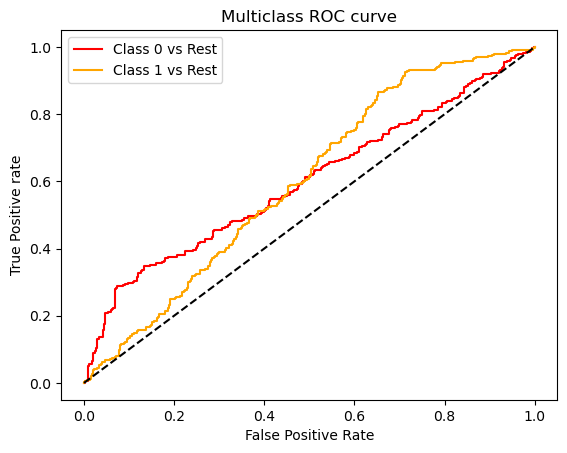

In [18]:
fpr = {}
tpr = {}
thresh = {}
n_class = imp_df['Basket_Size'].nunique()
print(n_class)
classes = nb.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_NB[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_NB[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_NB_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    
# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_NB_ROC.png')

## Random Forest

In [19]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.652
Accuracy on test set: 0.577
Mjority classifier Confusion Matrix
 [[215 176]
 [133 206]]
              precision    recall  f1-score   support

           0   0.617816  0.549872  0.581867       391
           1   0.539267  0.607670  0.571429       339

    accuracy                       0.576712       730
   macro avg   0.578542  0.578771  0.576648       730
weighted avg   0.581339  0.576712  0.577020       730



Class 0 ROC AUC OvR: 0.6229
Class 1 ROC AUC OvR: 0.6229
Average ROC AUC OvR: 0.6229


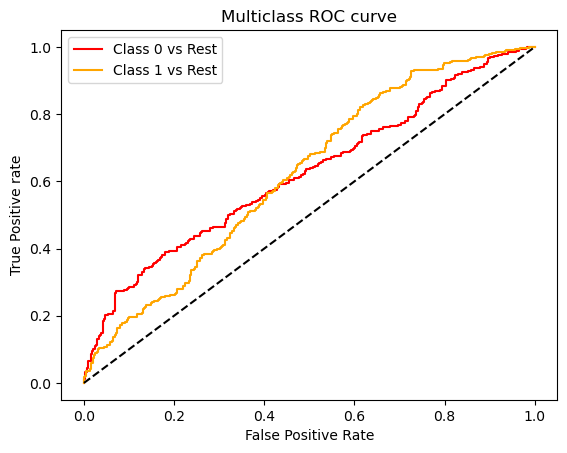

In [20]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Basket_Size'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_RF_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_RF_ROC.png')

# KNN

In [21]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(KNN.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(KNN.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

with open('BASKETSIZE_KNN_ACC.txt', 'w') as f:
    f.write("Accuracy on training set: {:.3f}\n".format(KNN.score(X_train, y_train)))
    f.write("Accuracy on test set: {:.3f}\n".format(KNN.score(X_test, y_test)))
    f.write('Mjority classifier Confusion Matrix\n')
    f.write(str(confusion_majority))
    
prob_KNN = KNN.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=KNN.predict(X_test))
print(sk_report)

Accuracy on training set: 0.782
Accuracy on test set: 0.536
Mjority classifier Confusion Matrix
 [[310  81]
 [258  81]]
              precision    recall  f1-score   support

           0   0.545775  0.792839  0.646507       391
           1   0.500000  0.238938  0.323353       339

    accuracy                       0.535616       730
   macro avg   0.522887  0.515888  0.484930       730
weighted avg   0.524518  0.535616  0.496440       730



Class 0 ROC AUC OvR: 0.5475
Class 1 ROC AUC OvR: 0.5475
Average ROC AUC OvR: 0.5475


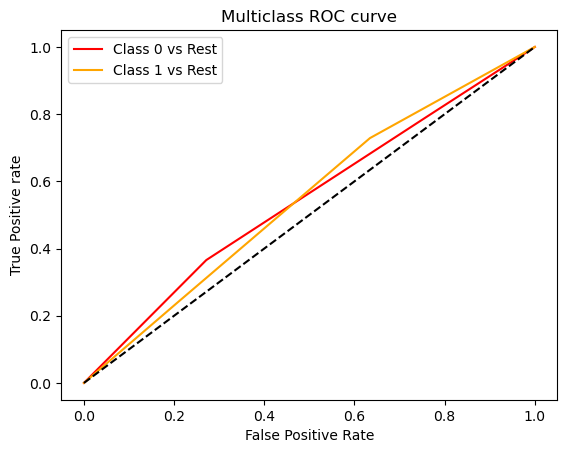

In [22]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Basket_Size'].nunique()
classes = KNN.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_KNN[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_KNN[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_KNN_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_KNN_ROC.png')

## RF TUNING

In [23]:
rf = RandomForestClassifier(random_state=1, n_estimators=500, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.654
Accuracy on test set: 0.582
Mjority classifier Confusion Matrix
 [[217 174]
 [131 208]]
              precision    recall  f1-score   support

           0   0.623563  0.554987  0.587280       391
           1   0.544503  0.613569  0.576976       339

    accuracy                       0.582192       730
   macro avg   0.584033  0.584278  0.582128       730
weighted avg   0.586849  0.582192  0.582495       730



Class 0 ROC AUC OvR: 0.6224
Class 1 ROC AUC OvR: 0.6224
Average ROC AUC OvR: 0.6224


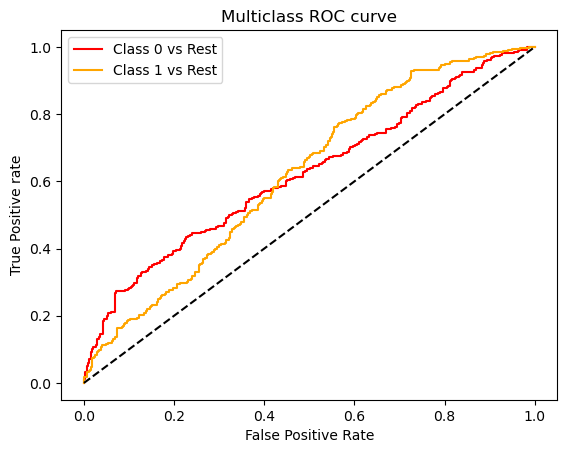

In [24]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Basket_Size'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_RF_1_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_RF_1_ROC.png')

In [25]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf.predict(X_test))
print(sk_report)

Accuracy on training set: 0.901
Accuracy on test set: 0.540
Mjority classifier Confusion Matrix
 [[215 176]
 [160 179]]
              precision    recall  f1-score   support

           0   0.573333  0.549872  0.561358       391
           1   0.504225  0.528024  0.515850       339

    accuracy                       0.539726       730
   macro avg   0.538779  0.538948  0.538604       730
weighted avg   0.541241  0.539726  0.540225       730



Class 0 ROC AUC OvR: 0.5945
Class 1 ROC AUC OvR: 0.5945
Average ROC AUC OvR: 0.5945


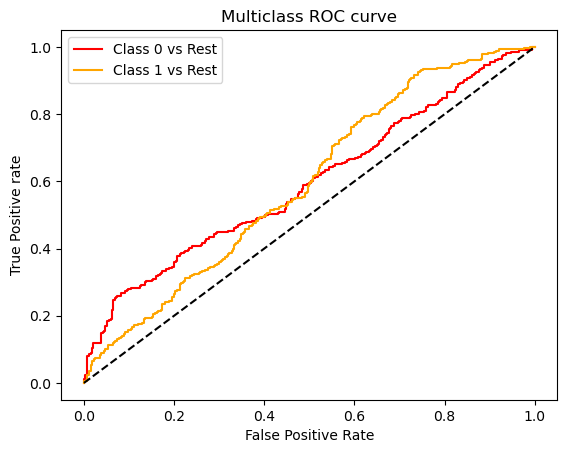

In [26]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Basket_Size'].nunique()
classes = rf.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_RF[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_RF[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_RF_2_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_RF_2_ROC.png')

## Ensemble

In [27]:

estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = KNeighborsClassifier(n_neighbors=3)
estimators.append(('knn', model2))
model3 = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=10)

estimators.append(('rf', model3))
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("Accuracy on training set: {:.3f}".format(ensemble.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ensemble.score(X_test, y_test)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_ESB = rf.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=ensemble.predict(X_test))
print(sk_report)

Accuracy on training set: 0.829
Accuracy on test set: 0.553
Accuracy Score : 0.5534246575342465
Precision Score : 0.521311475409836
Recall Score : 0.4690265486725664
F1 Score : 0.49378881987577633
Mjority classifier Confusion Matrix
 [[245 146]
 [180 159]]
              precision    recall  f1-score   support

           0   0.576471  0.626598  0.600490       391
           1   0.521311  0.469027  0.493789       339

    accuracy                       0.553425       730
   macro avg   0.548891  0.547813  0.547140       730
weighted avg   0.550856  0.553425  0.550940       730



>lr 0.552 (0.020)
>knn 0.535 (0.026)
>cart 0.534 (0.025)
>svm 0.547 (0.021)
>bayes 0.561 (0.022)
>stacking 0.549 (0.024)


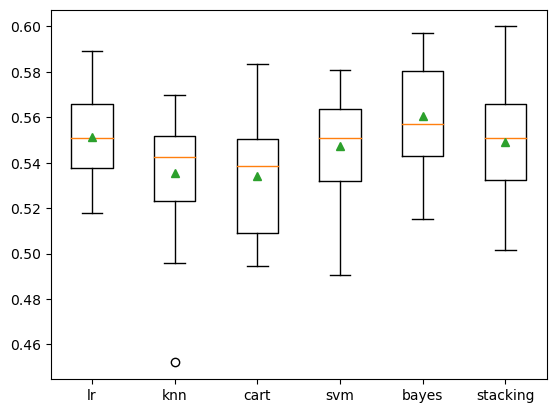

In [28]:
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
level1 = LogisticRegression()
stacked_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

models = dict()
models['lr'] = LogisticRegression()
models['knn'] = KNeighborsClassifier()
models['cart'] = DecisionTreeClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['stacking'] = stacked_model

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# SVM

In [29]:
# svm
svc = SVC( probability=True, random_state=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test, y_test)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
prob_svc = svc.predict_proba(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=svc.predict(X_test))
print(sk_report)

Accuracy on training set: 0.553
Accuracy on test set: 0.541
Accuracy Score : 0.541095890410959
Precision Score : 0.5188679245283019
Recall Score : 0.16224188790560473
F1 Score : 0.24719101123595508
Mjority classifier Confusion Matrix
 [[340  51]
 [284  55]]
              precision    recall  f1-score   support

           0   0.544872  0.869565  0.669951       391
           1   0.518868  0.162242  0.247191       339

    accuracy                       0.541096       730
   macro avg   0.531870  0.515904  0.458571       730
weighted avg   0.532796  0.541096  0.473628       730



Class 0 ROC AUC OvR: 0.5980
Class 1 ROC AUC OvR: 0.5980
Average ROC AUC OvR: 0.5980


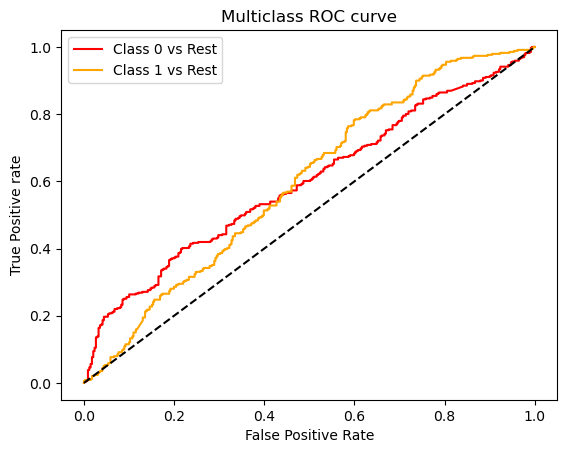

In [30]:
fpr = {}
tpr = {}
thresh ={}
n_class = imp_df['Basket_Size'].nunique()
classes = svc.classes_
roc_auc_ovr = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_svc[:,i], pos_label=i)
    c = classes[i]
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = prob_svc[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

avg_roc_auc = 0
i = 0
with open('BASKETSIZE_SVC_1_AUC.txt', 'w') as f:
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        f.write(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}\n")
        print(f"Class {k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    f.write(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='orange', label='Class 1 vs Rest')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best').figure.savefig('BASKETSIZE_SVC_1_ROC.png')